<a href="https://colab.research.google.com/github/ParitKansal/ReinforcementLearning-/blob/main/RL_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Import necessary libraries
import numpy as np # For numerical operations (like mean)
import matplotlib.pyplot as plt # For plotting results
import random # For random choices (exploration, tie-breaking)
from collections import defaultdict # Convenient for creating nested dictionaries for memory
from typing import Tuple, Dict, List, DefaultDict, Any # For type hinting

# Set random seeds for reproducibility
seed: int = 42
random.seed(seed)
np.random.seed(seed)

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

print("Libraries imported and seeds set.")

Libraries imported and seeds set.


In [7]:
class Environment:
    def __init__(self):
        # Grid size (10x10)
        self.rows: int = 10
        self.cols: int = 10

        # Define start and goal positions
        self.start_state: Tuple[int, int] = (0, 0)
        self.goal_state: Tuple[int, int] = (self.rows - 1, self.cols - 1)

        # Current agent position
        self.curr_state: Tuple[int, int] = self.start_state

        # Action map: maps action string -> (row_change, col_change)
        self.action_map: Dict[str, Tuple[int, int]] = {
            "up": (-1, 0),
            "down": (1, 0),
            "left": (0, -1),
            "right": (0, 1)
        }

        # Rewards
        self.wall_hitting_reward: float = -1.0   # penalty for hitting wall
        self.default_reward: float = -0.1        # small negative reward per step
        self.goal_reward: float = 10.0           # reward for reaching the goal

    # -------------------
    # Public methods (user-facing)
    # -------------------

    def reset(self) -> Tuple[int, int]:
        """Reset the environment to the starting position."""
        self.curr_state = self.start_state
        return self.curr_state

    def step(self, action: str):
        """
        Take one step in the environment based on the given action.
        Updates current state.
        Args:
            action (str): One of {"up", "down", "left", "right"}
        Returns:
            next_state (Tuple[int, int])
            reward (float)
            done (bool)
        """
        # If already at goal, return terminal state
        if self.curr_state == self.goal_state:
            return self.curr_state, 0.0, True

        # Compute next state and reward using private helpers
        next_state = self._compute_next_state(self.curr_state, action)
        reward = self._compute_reward(self.curr_state, action)

        # Check if goal reached
        done = (next_state == self.goal_state)

        # Update current state (only if valid move or goal reached)
        self.curr_state = next_state
        return next_state, reward, done

    def action_space(self) -> List[str]:
        """Return the list of all possible actions."""
        return list(self.action_map.keys())

    # -------------------
    # Private helper methods
    # -------------------

    def _compute_next_state(self, state: Tuple[int, int], action: str) -> Tuple[int, int]:
        """Internal helper: compute next state without modifying environment."""
        row_change, col_change = self.action_map[action]
        next_row = state[0] + row_change
        next_col = state[1] + col_change

        # If action goes outside grid, agent stays in the same place
        if not (0 <= next_row < self.rows and 0 <= next_col < self.cols):
            return state
        else:
            return (next_row, next_col)

    def _compute_reward(self, state: Tuple[int, int], action: str) -> float:
        """Internal helper: compute reward for state-action pair."""
        next_state = self._compute_next_state(state, action)

        if next_state == self.goal_state:
            return self.goal_reward
        elif next_state == state and state != self.goal_state:  # wall hit
            return self.wall_hitting_reward
        else:
            return self.default_reward

In [8]:
class GreedyAgent:
    def __init__(self, actions: List[str],
                 epsilon_start: float = 1.0,
                 epsilon_end: float = 0.01,
                 decay_rate: float = 0.001):
        """
        Greedy agent with epsilon-greedy exploration.
        Uses exponential decay schedule.
        """
        self.actions: List[str] = actions
        self.n_actions: int = len(actions)

        # memory[state][action] = (total_reward, count)
        self.memory: Dict[Tuple[int, int], Dict[str, Tuple[float, int]]] = defaultdict(
            lambda: defaultdict(lambda: (0.0, 0))
        )

        # Exploration parameters
        self.epsilon_start: float = epsilon_start
        self.epsilon_end: float = epsilon_end
        self.decay_rate: float = decay_rate
        self.epsilon: float = epsilon_start

    def reset(self) -> None:
        """Reset agent memory (forget everything)."""
        self.memory.clear()
        self.epsilon = self.epsilon_start

    def choose_action(self, state: Tuple[int, int]) -> str:
        """Choose an action based on epsilon-greedy policy."""
        if random.random() < self.epsilon:
            return random.choice(self.actions)  # exploration

        avg_rewards = {}
        for action in self.actions:
            total, count = self.memory[state][action]
            avg_rewards[action] = total / count if count > 0 else 0.0

        max_avg = max(avg_rewards.values())
        best_actions = [a for a, r in avg_rewards.items() if r == max_avg]
        return random.choice(best_actions)

    def update_memory(self, state: Tuple[int, int], action: str, reward: float) -> None:
        """Update running reward average for (state, action)."""
        total, count = self.memory[state][action]
        self.memory[state][action] = (total + reward, count + 1)

    def decay_epsilon(self, episode: int) -> None:
        """Decay epsilon using exponential schedule."""
        self.epsilon = max(
            self.epsilon_end,
            self.epsilon_start * np.exp(-self.decay_rate * episode)
        )

In [11]:
# Create environment and agent
env = Environment()
agent = GreedyAgent(actions=env.action_space(),
                    epsilon_start=1.0,
                    epsilon_end=0.01,
                    decay_rate=0.995)

NUM_EPISODES = 2000
MAX_STEPS = 150
episode_rewards = []
steps_length = []

for episode in range(NUM_EPISODES):
    state = env.reset()
    total_reward = 0.0
    steps_taken = 0

    for step in range(MAX_STEPS):
        # 1. Choose action
        action = agent.choose_action(state)

        # 2. Take action in environment
        next_state, reward, done = env.step(action)

        # 3. Update memory
        agent.update_memory(state, action, reward)

        # Track reward & state
        state = next_state
        total_reward += reward
        steps_taken += 1

        if done:
            break

    # Save episode stats
    episode_rewards.append(total_reward)
    steps_length.append(steps_taken)

    # Decay exploration rate
    agent.decay_epsilon(episode=episode)

    # Log every 500 episodes (not every 50, for speed)
    if (episode + 1) % 500 == 0:
        avg_reward = sum(episode_rewards[-500:]) / 500
        print(f"Episode {episode+1}, "
              f"Avg Reward (last 500): {avg_reward:.2f}, "
              f"Epsilon: {agent.epsilon:.3f}")

Episode 500, Avg Reward (last 500): -12.57, Epsilon: 0.010
Episode 1000, Avg Reward (last 500): -9.82, Epsilon: 0.010
Episode 1500, Avg Reward (last 500): -7.92, Epsilon: 0.010
Episode 2000, Avg Reward (last 500): -13.41, Epsilon: 0.010


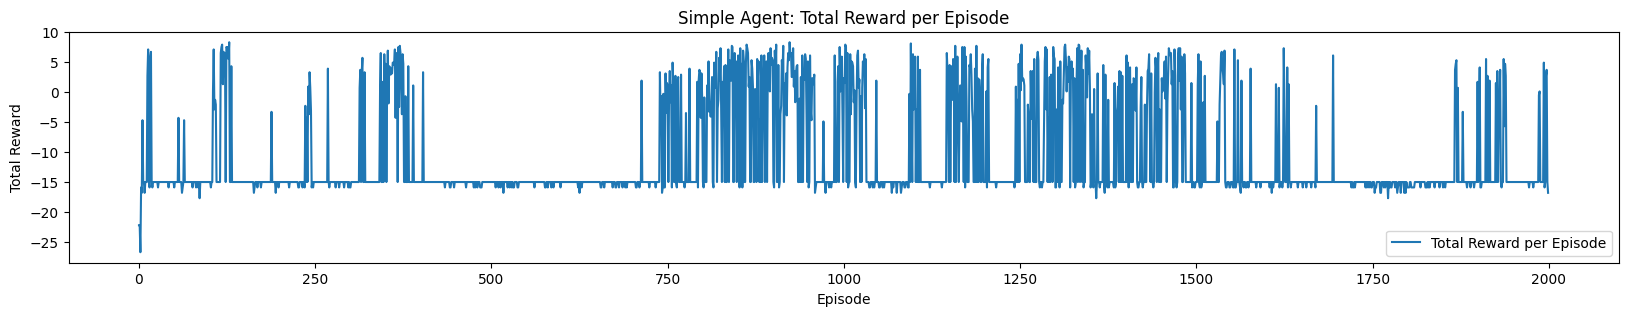

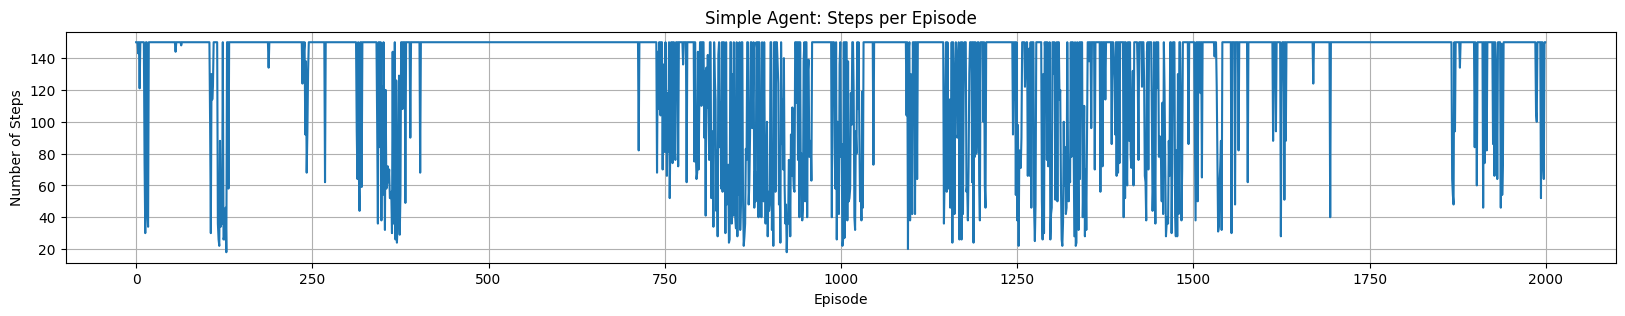

In [12]:
plt.figure(figsize=(20, 3))
plt.plot(episode_rewards, label='Total Reward per Episode')
plt.title('Simple Agent: Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

# Plotting episode lengths
plt.figure(figsize=(20, 3))
plt.plot(steps_length, label='Steps per Episode')
plt.title('Simple Agent: Steps per Episode')
plt.xlabel('Episode')
plt.ylabel('Number of Steps')
plt.grid(True)

plt.show()

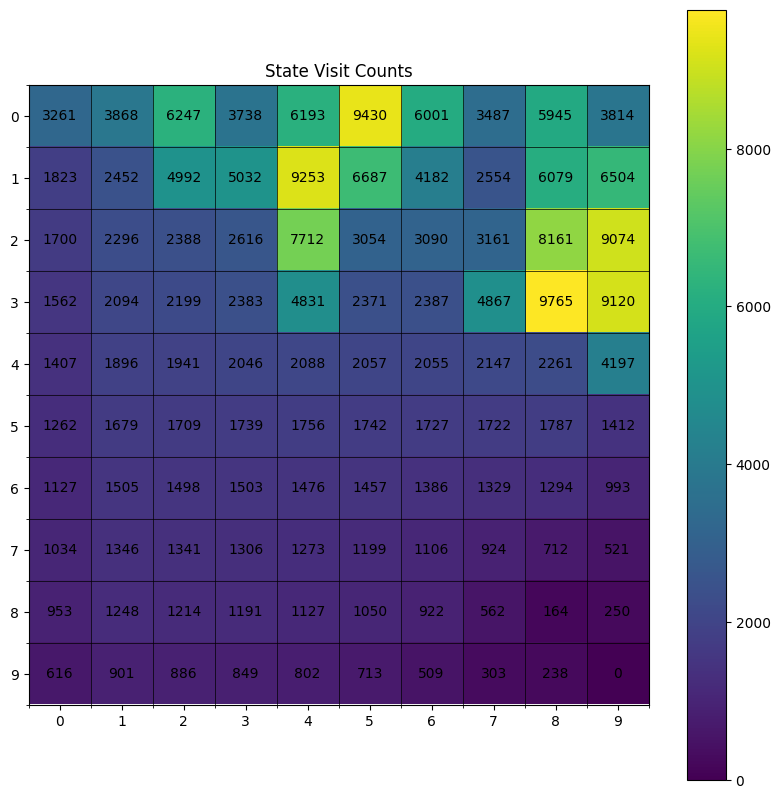

In [13]:
def plot_state_visitation(memory: Dict[Tuple[int, int], Dict[str, Tuple[float, int]]], env):
    """Plot heatmap of state visit counts."""
    rows, cols = env.rows, env.cols
    visit_counts = np.zeros((rows, cols), dtype=int)

    # Count visits to each state
    for (r, c), actions in memory.items():
        visit_counts[r, c] = sum(visits for _, visits in actions.values())

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(cols * 1, rows * 1))
    im = ax.imshow(visit_counts)

    # Annotate counts
    for r in range(rows):
        for c in range(cols):
            ax.text(c, r, str(visit_counts[r, c]), ha="center", va="center")

    ax.set_xticks(np.arange(cols))
    ax.set_yticks(np.arange(rows))
    ax.set_xticks(np.arange(-.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-.5, rows, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

    ax.set_title("State Visit Counts")
    plt.colorbar(im, ax=ax)
    plt.show()
plot_state_visitation(agent.memory, env)

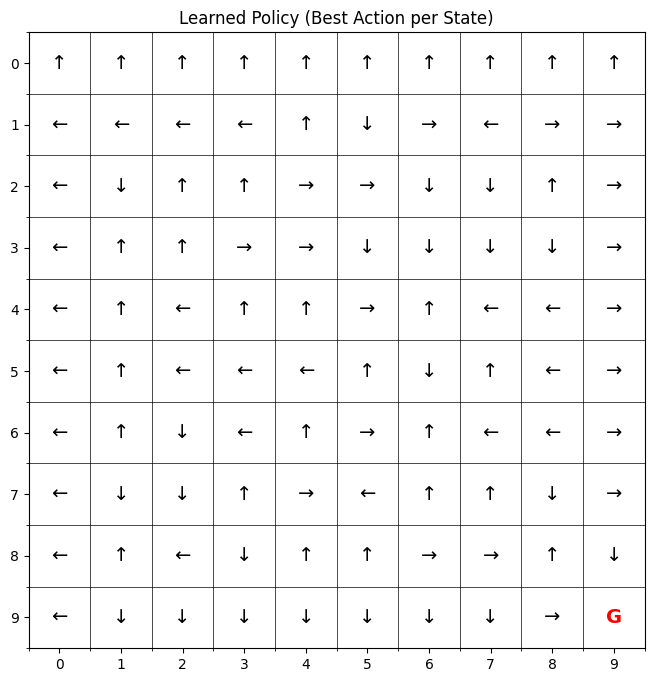

In [14]:
def plot_policy(memory, env):
    """
    Draw the best action (max avg reward) at each state.
    Uses agent's memory of (avg_reward, count).
    """
    rows, cols = env.rows, env.cols
    policy_grid = np.full((rows, cols), "", dtype=object)

    # Pick best action for each state
    for (r, c), action_dict in memory.items():
        if not action_dict:
            continue

        # Find action with highest avg reward
        best_action = max(action_dict.items(), key=lambda x: x[1][0])[0]

        # Map to arrow symbol
        if best_action == "up":
            policy_grid[r, c] = "↑"
        elif best_action == "down":
            policy_grid[r, c] = "↓"
        elif best_action == "left":
            policy_grid[r, c] = "←"
        elif best_action == "right":
            policy_grid[r, c] = "→"
        else:
            policy_grid[r, c] = "•"

    # Plot
    fig, ax = plt.subplots(figsize=(cols * 0.8, rows * 0.8))
    ax.imshow(np.zeros((rows, cols)), cmap="Greys", alpha=0.1)

    # Place arrows
    for r in range(rows):
        for c in range(cols):
            text = policy_grid[r, c]
            if text:
                ax.text(c, r, text, ha="center", va="center", fontsize=14)

    # Mark Start & Goal
    sr, sc = env.start_state
    gr, gc = env.goal_state
    ax.text(gc, gr, "G", ha="center", va="center", color="red", fontsize=14, fontweight="bold")

    ax.set_xticks(np.arange(cols))
    ax.set_yticks(np.arange(rows))
    ax.set_xticks(np.arange(-.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-.5, rows, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)

    ax.set_title("Learned Policy (Best Action per State)")
    plt.show()
plot_policy(agent.memory, env)